Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Training with sequence Length: 20 ===
Train Sequences: (14881, 20, 41) (14881, 1)
Test Sequences: (3650, 20, 41) (3650, 1)
Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - loss: 0.4027 - val_loss: 0.0578
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0809 - val_loss: 0.0279
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.0505 - val_loss: 0.0220
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - loss: 0.0432 - val_loss: 0.0193
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - loss: 0.0373 - val_loss: 0.0184
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.0332 - val_loss: 0.0173
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0294 - val_loss: 0.0169
Epoch 8/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - loss: 0.0268 - val_loss: 0.0162
Epoch 9/50
233/233 ━━━━━━━━━━━━━━━━━━━━

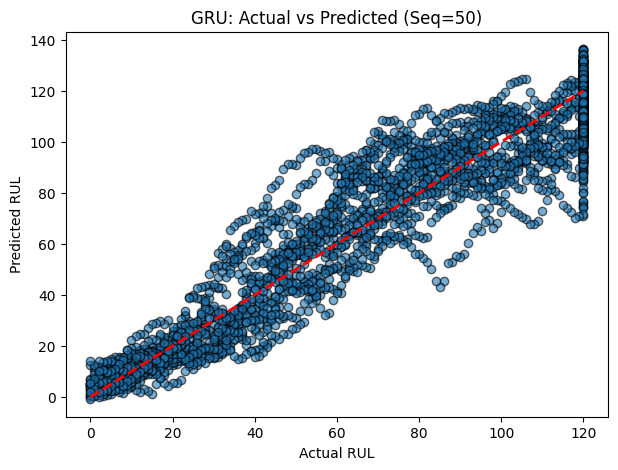

Saved Seq_length Analysis Results!
   seq_length   RMSE    MAE     R2
0          20  15.12  11.64  0.858
1          30  15.06  12.03  0.859
2          50  13.14   9.69  0.891


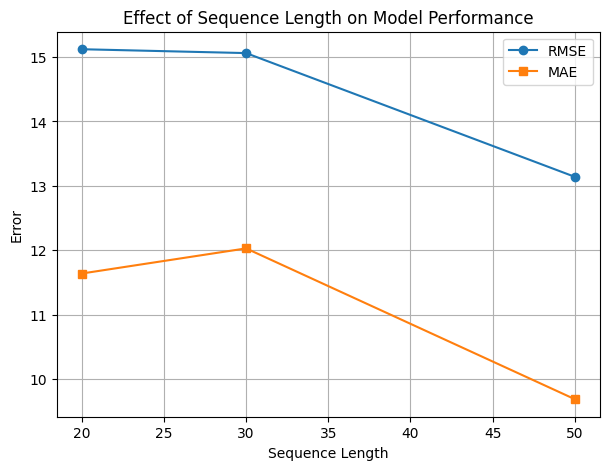

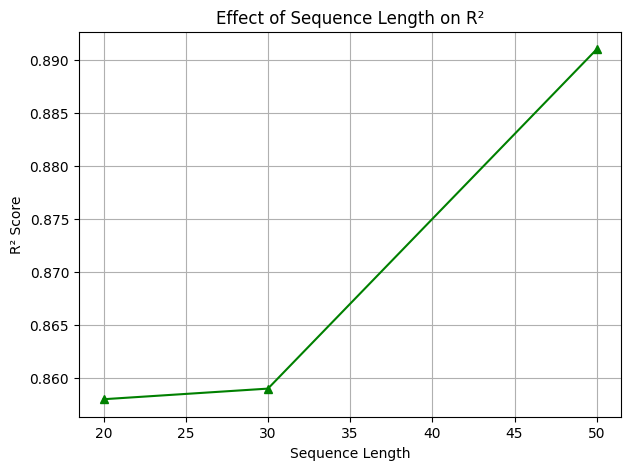


Day 05 processed dataset saved to: /content/drive/MyDrive/predictive_maintenance/processed_train_FD001_code 05.csv


In [2]:
### ------------------------------------------------------------------------- ###
# --- GRU Sequence Modeling for RUL Prediction --- (Using GRU (Gated Recurrent Units) to predict Remaining Useful Life (RUL))
### ------------------------------------------------------------------------- ###
from google.colab import drive
drive.mount('/content/drive')

# --- 1. Imports ---
# -------------------------------- #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU
from tensorflow.keras import Input

# --- 2. Load data
# ------------------------------------ #
file_path = '/content/drive/MyDrive/predictive_maintenance/processed_train_FD001.csv'
df = pd.read_csv(file_path)

# Add RUL Column --> to compute RUL for each row
df['RUL'] = df.groupby('unit_number')['time_in_cycles'].transform(lambda x: x.max() - x)
df['RUL'] = df['RUL'].clip(upper=120)
df.head()

# --- 3. Feature Scaling --> this part is to select sensor and operational settings as features
# -------------------------------------- #
final_features = [col for col in df.columns if 'sensor_measurement' in col or 'op_setting' in col]

scaler = StandardScaler()
df[final_features] = scaler.fit_transform(df[final_features])

# --- 4. Helper: Create Sequences
# ---------------------------------------- #
def create_sequences(df, seq_length, features, target_col):   # purpose of creating sequences for outer loop is to work on engine separately
    X, y = [], []    # empty arrays to collect target data,   # and for inner loop is to slide a window length over this engine's data to make input-output pairs for the model.
    for engine_id in df['unit_number'].unique():
        engine_data = df[df['unit_number'] == engine_id]
        feature_array = engine_data[features].values
        target_array = engine_data[target_col].values

        for i in range(len(feature_array) - seq_length + 1):
            X.append(feature_array[i:i+seq_length])
            y.append(target_array[i+seq_length-1])

    return np.array(X), np.array(y)

# --- 5. Train/Test Split
# -------------------------------------------- #
train_engines, test_engines = train_test_split(df['unit_number'].unique(), test_size=0.2, random_state=42)
train_seq_df = df[df['unit_number'].isin(train_engines)]   # again train/test split part to separate engines into training
test_seq_df = df[df['unit_number'].isin(test_engines)]     # and testing sets, as this is time-series data pr engine.

# --- 6. Train GRU Models with Different Sequence Length
# --------------------------------------------- #
seq_lengths = [20, 30, 50]
results = {}

for seq_length in seq_lengths:
  print(f"\n=== Training with sequence Length: {seq_length} ===")
  X_train_seq, y_train_seq = create_sequences(train_seq_df, seq_length, final_features, 'RUL')
  X_test_seq, y_test_seq = create_sequences(test_seq_df, seq_length, final_features, 'RUL')

  # Scale target
  y_scaler = MinMaxScaler()
  y_train_seq = y_scaler.fit_transform(y_train_seq.reshape(-1, 1))
  y_test_seq  = y_scaler.transform(y_test_seq.reshape(-1, 1))

  print("Train Sequences:", X_train_seq.shape, y_train_seq.shape)
  print("Test Sequences:", X_test_seq.shape, y_test_seq.shape)

# --- GRU Model
# ------------------------------------------------- #
  gru_model = Sequential([                               # purpose of training gru model is to specify the shape of the input data.
      Input(shape=(seq_length, len(final_features))),
      GRU(128, return_sequences=True),
      Dropout(0.3),
      GRU(64, return_sequences=False),
      Dropout(0.3),
      Dense(32, activation='relu'),
      Dense(1)
  ])

  gru_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

  es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the GRU model
  history_gru = gru_model.fit(
     X_train_seq, y_train_seq,
     validation_data=(X_test_seq, y_test_seq),
     epochs=50,     # epoch is a one full pass of the training data through the neural network and purpose of epoch is that with each epoch, weights get updated via backpropagation, and the model learns better patterns from the data.
     batch_size=64,   # Higher epochs give the network more chances to learn.
     callbacks=[es],
     verbose=1
  )

# --- 7. Evaluate GRU Performance
# ------------------------------------------------------ #
  y_pred_gru = gru_model.predict(X_test_seq)
  y_pred_gru = y_scaler.inverse_transform(y_pred_gru)
  y_test_seq_inv = y_scaler.inverse_transform(y_test_seq)

  rmse_gru = np.sqrt(mean_squared_error(y_test_seq_inv, y_pred_gru))
  mae_gru = mean_absolute_error(y_test_seq_inv, y_pred_gru)
  r2_gru = r2_score(y_test_seq_inv, y_pred_gru)


  print(f"Seq {seq_length} → RMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}, R2: {r2_gru:.3f}")
  results[seq_length] = (rmse_gru, mae_gru, r2_gru)

# Result Summary
print("\n=== Final Results Across Sequence Lengths ===")
for seq_len, (rmse_gru, mae_gru, r2_gru) in results.items():
  print(f"seq Length {seq_len}: RMSE ={rmse_gru:.2f}, MAE={mae_gru:.2F}, R2={r2_gru:.3f}")

# --- 8. Plot Actual vs Predicted ---
# ------------------------------------------------------------- #
plt.figure(figsize=(7,5))
plt.scatter(y_test_seq_inv, y_pred_gru, alpha=0.6, edgecolors='k')
plt.plot([y_test_seq_inv.min(), y_test_seq_inv.max()],
         [y_test_seq_inv.min(), y_test_seq_inv.max()],
         'r--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title(f'GRU: Actual vs Predicted (Seq={seq_length})')
plt.show()

# ----------------------------------------------------------------- #
# --- 9. Sequence Length Analysis Results ---
# -------------------------------------------------- #
results = {
    'seq_length' : [20,30,50],
    'RMSE' : [15.12, 15.06, 13.14],
    'MAE' : [11.64, 12.03, 9.69],
    'R2' : [0.858, 0.859, 0.891]
}

df_results = pd.DataFrame(results)

# Save the file in drive
df_results.to_csv("/content/drive/MyDrive/predictive_maintenance/day05_results.csv", index=False)
print("Saved Seq_length Analysis Results!")
print(df_results)

# --- 10. Plot the results
# ----------------------------------------------------- #
# Plot RMSE vs sequence length
plt.figure(figsize=(7,5))
plt.plot(df_results["seq_length"], df_results["RMSE"], marker="o", label="RMSE")
plt.plot(df_results["seq_length"], df_results["MAE"], marker="s", label="MAE")
plt.title("Effect of Sequence Length on Model Performance")
plt.xlabel("Sequence Length")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# Plot R2 separately
plt.figure(figsize=(7,5))
plt.plot(df_results["seq_length"], df_results["R2"], marker="^", color="green")
plt.title("Effect of Sequence Length on R²")
plt.xlabel("Sequence Length")
plt.ylabel("R² Score")
plt.grid(True)
plt.show()

# -------------------------------------------------------------- #
# --- 11. Save the processeed data ---
# -------------------------------------------------------------- #
output_path = "/content/drive/MyDrive/predictive_maintenance/processed_train_FD001_code 05.csv"
df.to_csv(output_path, index=False)
print(f"\nCode 05 processed dataset saved to: {output_path}")

# =============================================================== #
# Summary

# We observed through the results that GRU model processes of sensor features, captures temporal patterns,
# and predicts a single RUL valur.Dropout layers help prevent overfitting.
# Also gru model is simpler and faster than LSTM but still capable of capturing temporal dependencies in sequential data.
# Helps the model understand **how sensor readings evolve per cycles**.

# =============================================================== #

